In [334]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from src.model import FacenetFineTuned
from pytorch_grad_cam.grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image


In [335]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Model

In [336]:
PATH = 'facenetfinetuned.pth'

model = FacenetFineTuned(pretrained='casia-webface')
model.load_state_dict(torch.load(PATH, map_location='cpu'))
model.eval()

FacenetFineTuned(
  (resnet): InceptionResnetV1(
    (conv2d_1a): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2a): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2b): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2d_3b): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=Tr

In [337]:
target_layer = model.resnet.block8 # Last block before classifier head
target_layer

Block8(
  (branch0): BasicConv2d(
    (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (branch1): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): BasicConv2d(
      (conv): Conv2d(192, 192, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): BasicConv2d(
      (conv): Conv2d(192, 192, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (conv2d): Conv2d(384, 1792, kernel_size=(1, 1), str

## Image fake component

<img src='https://github.com/minostauros/Real-and-Fake-Face-Detection/raw/master/filename_description.jpg' width=800 height=400>

## Sample Image

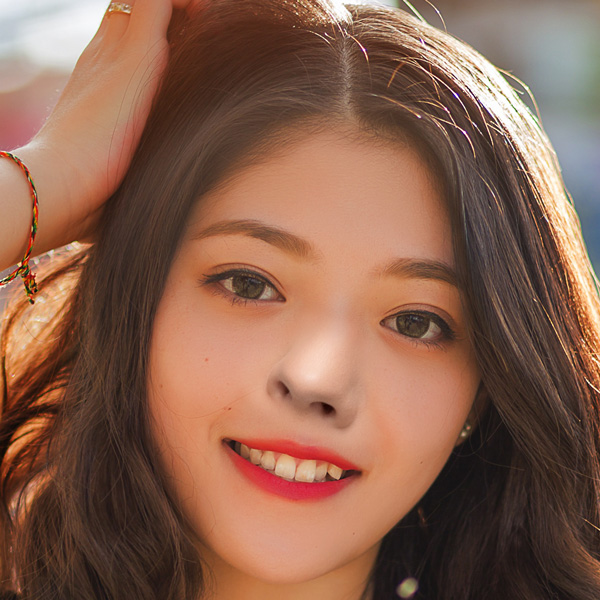

In [338]:
img_path = 'easy_212_0010.jpg'

img = Image.open(img_path).resize((600, 600))
img

In [339]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [340]:
img_transformed = transforms(img)
img_transformed = img_transformed.unsqueeze(dim=0)
img_transformed.shape

torch.Size([1, 3, 600, 600])

In [341]:
class_map = {0: "Fake", 1: "Real"}
pred_proba = torch.sigmoid(model(img_transformed))
output_class = (pred_proba > 0.5).to(torch.int)
print(f"The prediction for this image is: {class_map[output_class.item()]}")

The prediction for this image is: Fake


In [342]:
for params in model.parameters():
    params.requires_grad = True

img = np.float32(img) / 255
input_tensor = preprocess_image(img)
cam = GradCAM(model=model, target_layers=[target_layer])
fake_cam = cam(input_tensor=input_tensor)
cam_image = show_cam_on_image(img, fake_cam[0, :], use_rgb=True)


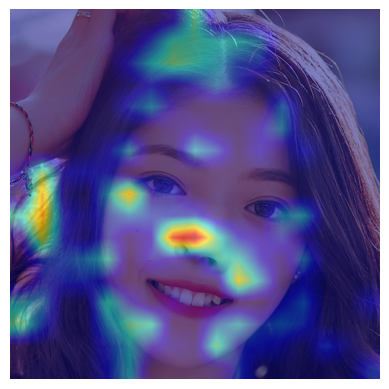

In [343]:
plt.imshow(cam_image)
plt.axis("off")
plt.show()